In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

The FixOurFood Dashboard utilizes food supply data from FAOSTAT to describe dietary patterns and estimate their impact and the impact of interventions on multiple indicators derived from it.
Latest FAOSTAT data can be downloaded from the FAO website:
- https://www.fao.org/faostat/en/#data/FBSH for data released until 2013 utilizing old methodology
- https://www.fao.org/faostat/en/#data/FBS for data published since 2014 utilizing new methodology

The raw datasets are obtained directly from both sites using the following filtering:

- Countries: United Kingdom of Great Britain and Northern Ireland
- Elements: Food, Food supply, Food supply quantity, Fat supply quantity, Protein supply quantity 
- Items: Select all except *Population*
- Years: Select all for FBSH and 2014-2019 for FBS 

This will create 2 CSV files which we rename
`FAOSTAT_food_data_UK_1961_2013.csv`
`FAOSTAT_food_data_UK_2014_2019.csv`


The FixOurFood dashboard presents dietary patterns and emissions estimated from food supply reported from FAO.
Values for the UK are used here.
    In this notebook, the values are extracted and stored in an easy to manage numpy file which is then read by the main dashboard script.
    

In [2]:
fbs_csv_1 = '../../data/food/FoodBalanceSheetsHistoric_E_All_Data_(Normalized).csv'
fbs_csv_2 = '../../data/food/FoodBalanceSheets_E_All_Data_(Normalized).csv'

In [3]:
fbs_1 = pd.read_csv(fbs_csv_1, encoding = 'latin1') # 1961 - 2013
fbs_2 = pd.read_csv(fbs_csv_2, encoding = 'latin1') # 2010 - 2020

# We will prefer new methodology over old, so will drop 2010-2013 year range from old data
fbs_1 = fbs_1[fbs_1['Year'].isin(np.arange(1961, 2010))]

fbs = pd.concat([fbs_1, fbs_2], ignore_index=True, sort=False)
fbs = fbs[fbs['Area Code'] == 229]

fbs = fbs[['Element', 'Element Code', 'Item', 'Item Code', 'Year', 'Unit', 'Value']]
years = np.unique(fbs['Year'])

'Rice and products' and 'Groundnuts' changed name and code from one methodology to another. We will keep the new codes and names

'Miscellaneous', 'Milk - Excluding Butter' and 'Eggs' have two different measurement flags, each with a different 'Item Code'. Will keep the highest Item Code: 2948 & 2949 for the later two.

In [4]:
nuts_old_code = fbs_1[fbs_1['Item'] == 'Groundnuts (Shelled Eq)'].iloc[0]['Item Code']
rice_old_code = fbs_1[fbs_1['Item'] == 'Rice (Milled Equivalent)'].iloc[0]['Item Code']

nuts_new_code = fbs_2[fbs_2['Item'] == 'Groundnuts'].iloc[0]['Item Code']
rice_new_code = fbs_2[fbs_2['Item'] == 'Rice and products'].iloc[0]['Item Code']

milk_codes = pd.unique(fbs[fbs['Item'] == 'Milk - Excluding Butter']['Item Code'])
eggs_codes = pd.unique(fbs[fbs['Item'] == 'Eggs']['Item Code'])


print(f'Groundnuts: old code = {nuts_old_code}, new code = {nuts_new_code}')
print(f'Rice and products: old code = {rice_old_code}, new code = {rice_new_code}')

print('Milk codes:', milk_codes)
print('Eggs codes:', eggs_codes)

Groundnuts: old code = 2556, new code = 2552
Rice and products: old code = 2805, new code = 2807
Milk codes: [2948 2848]
Eggs codes: [2949 2744]


In [5]:
# We'll rename some of the items due to changes in naming convention
fbs.loc[fbs['Item Code'] == rice_old_code, 'Item'] = "Rice and products"
fbs.loc[fbs['Item Code'] == rice_old_code, 'Item Code'] = rice_new_code

fbs.loc[fbs['Item Code'] == nuts_old_code, 'Item'] = "Groundnuts"
fbs.loc[fbs['Item Code'] == nuts_old_code, 'Item Code'] = nuts_new_code

# Also, will remove the 'Miscellaneous' item as it has incomplete data
fbs.drop(fbs.loc[fbs['Item'] == 'Miscellaneous'].index, inplace=True)

# Also, will remove the 'Miscellaneous' item as it has incomplete data
fbs.drop(fbs.loc[fbs['Item'] == 'Grand Total'].index, inplace=True)

# Finally, drop all duplicates of Eggs and Milk
fbs.drop(fbs.loc[fbs['Item Code'].isin([milk_codes[1], eggs_codes[1]])].index, inplace=True)


Food items are identified by the `"Item Code"` column.

In [6]:
item_names = pd.unique(fbs['Item'])
item_codes = pd.unique(fbs['Item Code'])

# print(len(item_names),len(item_codes))

for name, code in zip(item_names, item_codes):
    print(code, name)
    
# for code in item_codes:
#     print(pd.unique(fbs[fbs['Item Code'] == code]['Item']), code)
    
# for name in item_names:
#     print(pd.unique(fbs[fbs['Item'] == name]['Item Code']), name)

2501 Population
2903 Vegetal Products
2941 Animal Products
2905 Cereals - Excluding Beer
2511 Wheat and products
2807 Rice and products
2513 Barley and products
2514 Maize and products
2515 Rye and products
2516 Oats
2517 Millet and products
2518 Sorghum and products
2520 Cereals, Other
2907 Starchy Roots
2532 Cassava and products
2531 Potatoes and products
2533 Sweet potatoes
2535 Yams
2534 Roots, Other
2908 Sugar Crops
2536 Sugar cane
2537 Sugar beet
2909 Sugar & Sweeteners
2542 Sugar (Raw Equivalent)
2543 Sweeteners, Other
2745 Honey
2911 Pulses
2546 Beans
2547 Peas
2549 Pulses, Other and products
2912 Treenuts
2551 Nuts and products
2913 Oilcrops
2555 Soyabeans
2552 Groundnuts
2557 Sunflower seed
2558 Rape and Mustardseed
2559 Cottonseed
2560 Coconuts - Incl Copra
2561 Sesame seed
2562 Palm kernels
2563 Olives (including preserved)
2570 Oilcrops, Other
2914 Vegetable Oils
2571 Soyabean Oil
2572 Groundnut Oil
2573 Sunflowerseed Oil
2574 Rape and Mustard Oil
2575 Cottonseed Oil
2576 

Different information and values are encoded by the `"Element code"`:

In [7]:
element_codes = pd.unique(fbs['Element Code'])
element_names = pd.unique(fbs['Element'])
element_units= []

for code in element_codes:
    unit = fbs[fbs['Element Code'] == code].iloc[0]['Unit']
    element_units.append(unit)
    
for i, (code, name) in enumerate(zip(element_codes, element_names)):
    print(code, element_units[i], name )


511 1000 persons Total Population - Both sexes
664 kcal/capita/day Food supply (kcal/capita/day)
674 g/capita/day Protein supply quantity (g/capita/day)
684 g/capita/day Fat supply quantity (g/capita/day)
5511 1000 tonnes Production
5611 1000 tonnes Import Quantity
5072 1000 tonnes Stock Variation
5911 1000 tonnes Export Quantity
5301 1000 tonnes Domestic supply quantity
5521 1000 tonnes Feed
5527 1000 tonnes Seed
5123 1000 tonnes Losses
5131 1000 tonnes Processing
5154 1000 tonnes Other uses (non-food)
5142 1000 tonnes Food
645 kg Food supply quantity (kg/capita/yr)
5171 1000 tonnes Tourist consumption
5170 1000 tonnes Residuals


We can plot, for instance, the Bovine meat supply (`Element Code == 5142`, `Item Code == 2731`) for the whole year period

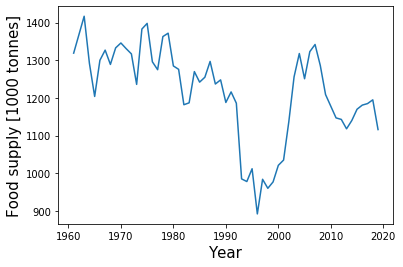

In [8]:
beef_supply = fbs[(fbs['Item Code'] == 2731) & (fbs['Element Code'] == 5142)]['Value']

plt.plot(years, beef_supply)
plt.xlabel('Year', size=15)
plt.ylabel('Food supply [1000 tonnes]', size=15);


# Fixing incomplete data

Checking for incomplete data shows that several Items have been renamed between the two year ranges, and some items without certain nutrients are ommited.
We will fix that to have a square array to facilitate usage.

In [9]:
# We check which items have no information on protein or fat contents and fill in with zero values

for year in years:
    print(year, end = ' ')
    for ec, ecode in enumerate(element_codes[1:]): # Wont be using Population
        for ic, icode in enumerate(item_codes[1:]): # Wont be using Population or Grand Total
            if fbs[(fbs['Year'] == year) & (fbs["Element Code"] == ecode) & (fbs["Item Code"] == icode)].empty:
                newrow = {'Element':element_names[ec+1],
                          'Element Code':ecode,
                          'Item':item_names[ic+1],
                          'Item Code':icode,
                          'Year':year,
                          'Unit':element_units[ec+1]}
                fbs=fbs.append(newrow, ignore_index=True)


1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 

# Food supply quantity per UN capita

We will add an Element to quantify the food supply per capita per day

- Food supply quantity UN population (kg/capita/day)

which will simplify the computations of emissions in the dashboard.
We will assign it a generic code `"Element Code == 10004"` for future identification
To calculate it we will divide the total Food supply by the region population, multiply by the number of days on a year and number of kilograms on 1000 tonnes 


In [10]:
# Add new element to lists
fbq_un_pop_name = 'Food supply quantity UN population (kg/capita/day)'
element_names = np.append(element_names, fbq_un_pop_name)
element_codes = np.append(element_codes, 10004)

# We copy an element and redefine its element code and name
fsq_un_pop = fbs[(fbs['Element Code']==5142)]
kwargs = {'Element Code':10004, 'Element':fbq_un_pop_name}
fsq_un_pop = fsq_un_pop.assign(**kwargs)

In [11]:
# Append food supply per UN capita
population = fbs[(fbs['Item Code'] == 2501) & (fbs['Element Code'] == 511)]['Value'].values

In [12]:
for icode in item_codes[1:]:
    f = fsq_un_pop[fsq_un_pop['Item Code'] == icode]['Value']
    if len(f) == 59:
        fsq_un_pop.loc[fsq_un_pop['Item Code'] == icode, 'Value'] = f * 1e6 / 365 / population / 1e3
    
fbs = fbs.append(fsq_un_pop, ignore_index=True)

In [13]:
# Final check, do all element codes have the same dimensions?
for code, codename in zip(element_codes, element_names):
    f_un_pop = fbs[fbs['Element Code'] == code]
    print(f_un_pop.shape,code,codename)

(59, 7) 511 Total Population - Both sexes
(6726, 7) 664 Food supply (kcal/capita/day)
(6726, 7) 674 Protein supply quantity (g/capita/day)
(6726, 7) 684 Fat supply quantity (g/capita/day)
(6726, 7) 5511 Production
(6726, 7) 5611 Import Quantity
(6726, 7) 5072 Stock Variation
(6726, 7) 5911 Export Quantity
(6736, 7) 5301 Domestic supply quantity
(6726, 7) 5521 Feed
(6726, 7) 5527 Seed
(6726, 7) 5123 Losses
(6726, 7) 5131 Processing
(6726, 7) 5154 Other uses (non-food)
(6726, 7) 5142 Food
(6726, 7) 645 Food supply quantity (kg/capita/yr)
(6726, 7) 5171 Tourist consumption
(6726, 7) 5170 Residuals
(6726, 7) 10004 Food supply quantity UN population (kg/capita/day)


In [15]:
fbs.to_csv('../../pyourfood/food/data/FAOSTAT.csv', index=False)